# DCGANs

Introduction to **Deep Convolutional Generative Adversarial Networks** or DCGANs. 

This notebook is organized as follows:

1. **Background**
2. **Definition**
3. **Training DCGANs with Keras and TensorFlow**

---

## 1. Background

Brief definition of some concepts, such as convolution and Convolutional Neural Network (CNN).

### Convolution

Convolution is a mathematical operation which describes a rule of how to mix two functions or pieces of information.

* Features Map $I$
* Convolution kernel $K$
* Map of transformed features $S(i, j)$

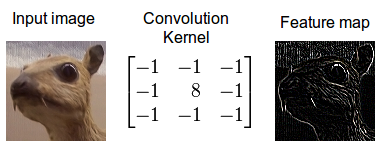

### Convolutional Neural Network (CNN)

Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers.

These convolutional layers have parameters that are learned so that these filters are adjusted automatically to extract the most useful information for the task at hand.

* Input is a multidimensional array of data,
* Kernel is a multidimensional array of parameters,
* These multidimensional arrays are tensors.

#### Layers CNN

* Convolution: extract features from imagem.
* Pooling: reduce dimension of entry.
* Dense / Fully connected: connect the layers.

## 2. Definition

The difference between the simple GAN and the DCGAN, is the generator of the simple GAN is a simple fully connected network. The generator of the DCGAN uses the transposed convolution (Fractionally-strided convolution or 
Deconvolution) technique to perform up-sampling of 2D image size.



## 3. Training DCGANs with Keras and TensorFlow

A DCGANs implementation using the transposed convolution technique and the [Keras](https://keras.io/) library.


### 1. Load data

#### Load libraries

In [2]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model
from keras import backend as K

Using TensorFlow backend.


#### Getting the data

In [4]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#### Explore visual data

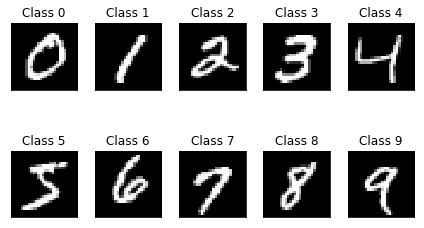

In [5]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [6]:
print('X_train.shape', X_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 28, 28, 1)


### 2. Define model

#### Generator

Our generator using the **inverse of convolution**, called transposed convolution. 

In between layers, BatchNormalization stabilizes learning. 

The activation function after each layer is a LeakyReLU. 

The output of the tanh at the last layer produces the fake image. 

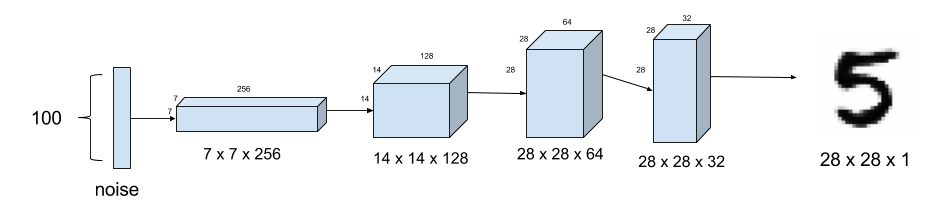

In [11]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC: 7x7x256
generator.add(Dense(7*7*128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((7, 7, 128)))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# # Conv 1: 14x14x128
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 2: 28x28x64
generator.add(Conv2DTranspose(32, kernel_size=5, strides=1, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 3: 28x28x32
# generator.add(Conv2DTranspose(32, kernel_size=5, strides=1, padding='same'))
# generator.add(BatchNormalization())
# generator.add(LeakyReLU(0.2))

# Conv 4: 28x28x1
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding='same',
                              activation='tanh'))

#### Generator model visualization

In [12]:
# prints a summary representation of your model
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
__________

#### Discriminator

Our discriminator is a **convolutional neural network** that takes a 28x28 image with 1 channel. The values in the image is expected to be between -1 and 1.

It takes a digit image and classifies whether an image is real (1) or not (0).

The last activation is sigmoid to tell us the probability of whether the input image is real or not.

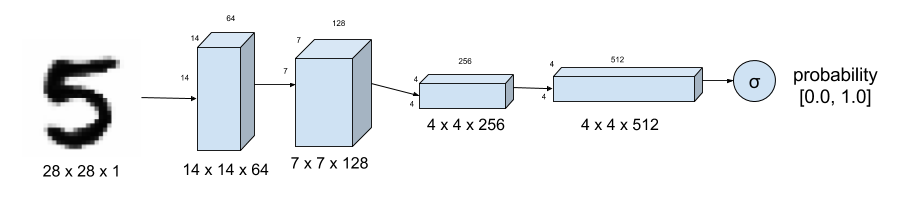

In [16]:
# Discriminator network
discriminator = Sequential()
# Conv 1: 14x14x64
discriminator.add(Conv2D(32, kernel_size=5, strides=2, padding='same',
                         input_shape=(28, 28, 1), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same'))
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(LeakyReLU(0.2))

# # Conv 3: 
# discriminator.add(Conv2D(512, kernel_size=5, strides=1, padding='same'))
# discriminator.add(LeakyReLU(0.2))

# # FC
discriminator.add(Flatten())
discriminator.add(LeakyReLU(0.2))

# # Output
discriminator.add(Dense(1, activation='sigmoid'))

#### Discriminator model visualization

In [17]:
# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
__________

### 3. Compile model

#### Compile discriminator

In [18]:
# Optimizer
opt = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(opt, loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

#### Combined network

We connect the generator and the discriminator to make a DCGAN.

In [19]:
# d_g = discriminador(generador(z))
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

d_g.compile(opt, loss='binary_crossentropy',
            metrics=['binary_accuracy'])

#### GAN model vizualization

In [20]:
# prints a summary representation of your model
d_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 28, 28, 1)         891265    
_________________________________________________________________
sequential_8 (Sequential)    (None, 1)                 259073    
Total params: 1,150,338
Trainable params: 890,817
Non-trainable params: 259,521
_________________________________________________________________


### 4. Fit model

We train the discriminator and the generator in turn in a loop as follows:

1. Set the discriminator trainable
2. Train the discriminator with the real digit images and the images generated by the generator to classify the real and fake images.
3. Set the discriminator non-trainable
4. Train the generator as part of the GAN. We feed latent samples into the GAN and let the generator to produce digit images and use the discriminator to classify the image.

epoch = 1/100, d_loss=0.669, g_loss=0.713                                                                                                                      


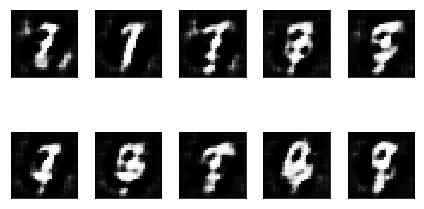

epoch = 2/100, d_loss=0.653, g_loss=0.758                                                                                                                      
epoch = 3/100, d_loss=0.653, g_loss=0.763                                                                                                                      
epoch = 4/100, d_loss=0.607, g_loss=0.872                                                                                                                      
epoch = 5/100, d_loss=0.600, g_loss=0.939                                                                                                                      
epoch = 6/100, d_loss=0.583, g_loss=1.005                                                                                                                      
epoch = 7/100, d_loss=0.554, g_loss=1.092                                                                                                                      
epoch = 8/100, d_loss=0.559, g_loss=1.07

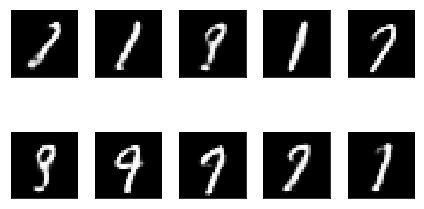

epoch = 12/100, d_loss=0.488, g_loss=1.226                                                                                                                      
epoch = 13/100, d_loss=0.457, g_loss=1.298                                                                                                                      
epoch = 14/100, d_loss=0.485, g_loss=1.295                                                                                                                      
epoch = 15/100, d_loss=0.448, g_loss=1.329                                                                                                                      
epoch = 16/100, d_loss=0.437, g_loss=1.470                                                                                                                      
epoch = 17/100, d_loss=0.480, g_loss=1.350                                                                                                                      
epoch = 18/100, d_loss=0.418, g_lo

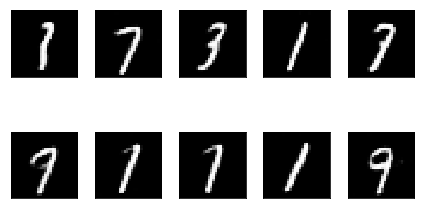

epoch = 22/100, d_loss=0.484, g_loss=1.306                                                                                                                      
epoch = 23/100, d_loss=0.400, g_loss=1.507                                                                                                                      
epoch = 24/100, d_loss=0.358, g_loss=1.547                                                                                                                      
epoch = 25/100, d_loss=0.474, g_loss=1.418                                                                                                                      
epoch = 26/100, d_loss=0.416, g_loss=1.475                                                                                                                      
epoch = 27/100, d_loss=0.410, g_loss=1.508                                                                                                                      
epoch = 28/100, d_loss=0.386, g_lo

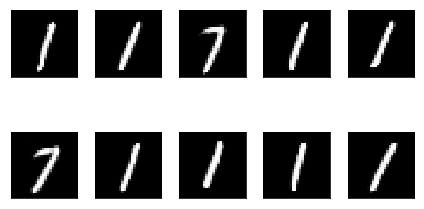

epoch = 32/100, d_loss=0.420, g_loss=1.676                                                                                                                      
epoch = 33/100, d_loss=0.352, g_loss=1.840                                                                                                                      
epoch = 34/100, d_loss=0.409, g_loss=1.600                                                                                                                      
epoch = 35/100, d_loss=0.402, g_loss=1.597                                                                                                                      
epoch = 36/100, d_loss=0.418, g_loss=1.679                                                                                                                      
epoch = 37/100, d_loss=0.402, g_loss=1.692                                                                                                                      
epoch = 38/100, d_loss=0.372, g_lo

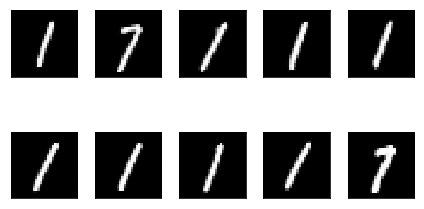

epoch = 42/100, d_loss=0.399, g_loss=1.734                                                                                                                      
epoch = 43/100, d_loss=0.370, g_loss=1.738                                                                                                                      
epoch = 44/100, d_loss=0.449, g_loss=1.675                                                                                                                      
epoch = 45/100, d_loss=0.415, g_loss=1.771                                                                                                                      
epoch = 46/100, d_loss=0.375, g_loss=1.777                                                                                                                      
epoch = 47/100, d_loss=0.409, g_loss=1.868                                                                                                                      
epoch = 48/100, d_loss=0.366, g_lo

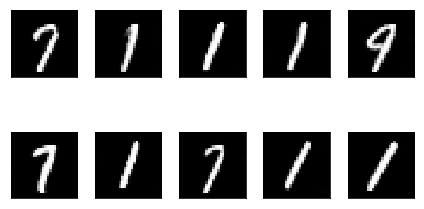

epoch = 52/100, d_loss=0.295, g_loss=2.007                                                                                                                      
epoch = 53/100, d_loss=0.384, g_loss=1.848                                                                                                                      
epoch = 54/100, d_loss=0.383, g_loss=1.976                                                                                                                      
epoch = 55/100, d_loss=0.369, g_loss=1.909                                                                                                                      
epoch = 56/100, d_loss=0.396, g_loss=1.724                                                                                                                      
epoch = 57/100, d_loss=0.380, g_loss=1.854                                                                                                                      
epoch = 58/100, d_loss=0.373, g_lo

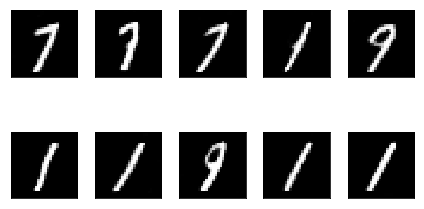

epoch = 62/100, d_loss=0.449, g_loss=2.060                                                                                                                      
epoch = 63/100, d_loss=0.414, g_loss=2.147                                                                                                                      
epoch = 64/100, d_loss=0.390, g_loss=2.042                                                                                                                      
epoch = 65/100, d_loss=0.374, g_loss=1.963                                                                                                                      
epoch = 66/100, d_loss=0.351, g_loss=2.097                                                                                                                      
epoch = 67/100, d_loss=0.428, g_loss=2.049                                                                                                                      
epoch = 68/100, d_loss=0.336, g_lo

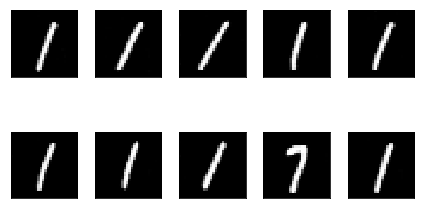

epoch = 72/100, d_loss=0.394, g_loss=2.090                                                                                                                      
epoch = 73/100, d_loss=0.329, g_loss=2.161                                                                                                                      
epoch = 74/100, d_loss=0.322, g_loss=2.276                                                                                                                      
epoch = 75/100, d_loss=0.270, g_loss=2.526                                                                                                                      
epoch = 76/100, d_loss=0.326, g_loss=2.067                                                                                                                      
epoch = 77/100, d_loss=0.326, g_loss=2.169                                                                                                                      
epoch = 78/100, d_loss=0.289, g_lo

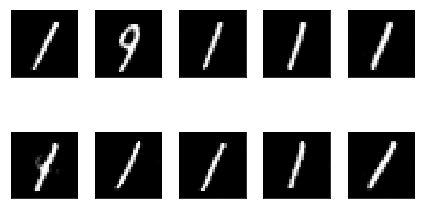

epoch = 82/100, d_loss=0.359, g_loss=2.411                                                                                                                      
epoch = 83/100, d_loss=0.383, g_loss=2.511                                                                                                                      
epoch = 84/100, d_loss=0.275, g_loss=2.457                                                                                                                      
epoch = 85/100, d_loss=0.286, g_loss=2.520                                                                                                                      
epoch = 86/100, d_loss=0.330, g_loss=2.400                                                                                                                      
epoch = 87/100, d_loss=0.224, g_loss=2.689                                                                                                                      
epoch = 88/100, d_loss=0.293, g_lo

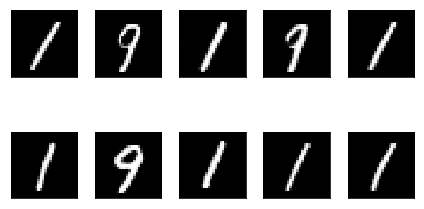

epoch = 92/100, d_loss=0.278, g_loss=2.662                                                                                                                      
epoch = 93/100, d_loss=0.300, g_loss=2.508                                                                                                                      
epoch = 94/100, d_loss=0.258, g_loss=2.942                                                                                                                      
epoch = 95/100, d_loss=0.303, g_loss=2.710                                                                                                                      
epoch = 96/100, d_loss=0.272, g_loss=2.362                                                                                                                      
epoch = 97/100, d_loss=0.319, g_loss=2.633                                                                                                                      
epoch = 98/100, d_loss=0.333, g_lo

In [21]:
epochs = 100
batch_size = 64

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch, y=real)
        
        # Fake Samples
        # z = np.random.uniform(size=(batch_size, latent_dim))
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.uniform(size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

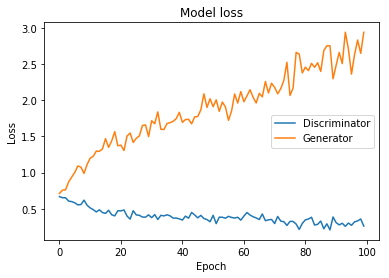

In [22]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator'], loc='center right')
plt.show()

## References

* [Generative Adversarial Networks or GANs](https://arxiv.org/abs/1406.2661)
* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
* [THE MNIST DATABASE of handwritten digits](http://yann.lecun.com/exdb/mnist/)
* [Convolution](https://devblogs.nvidia.com/deep-learning-nutshell-core-concepts/)